# Deconvolving the Mixing Matrix

The goal of this notebook is showcase the natural unmixing method to account for masking in the fields implemented in Heracles.


In [26]:
import heracles
import numpy as np
import heracles.healpy
from heracles.result import Result, truncated

import matplotlib.pyplot as plt
from heracles.notebook import Progress

import helpers

with Progress("example data") as progress:
    helpers.get_example_data(progress)

VBox()

In [27]:
def plot_clustering(cls, theory):
    bins = [key[3] for key in cls.keys()]
    nbins = max(bins) + 1
    fig, ax = plt.subplots(
        nbins - 1, nbins - 1, figsize=(6, 6), sharex=True, sharey=True
    )

    for i in range(1, nbins):
        for j in range(1, i):
            ax[j - 1, i - 1].axis("off")
        for j in range(i, nbins):
            ax[j - 1, i - 1].plot(
                cls["POS", "POS", i, j].ell[1:],
                cls["POS", "POS", i, j][1:],
                c="C0",
                lw=1.5,
                zorder=3.0,
                alpha=0.5,
            )
            ax[j - 1, i - 1].plot(
                theory["POS", "POS", i, j].ell[1:],
                theory["POS", "POS", i, j][1:],
                c="C0",
                lw=1.0,
                zorder=4.0,
            )
            ax[j - 1, i - 1].axhline(0.0, c="k", lw=0.8, zorder=-1)
            ax[j - 1, i - 1].tick_params(axis="both", which="both", direction="in")

    ax[0, 0].set_xscale("log")
    ax[0, 0].set_xlim(1 / 3, lmax * 3)
    ax[0, 0].xaxis.get_major_locator().set_params(numticks=99)
    ax[0, 0].xaxis.get_minor_locator().set_params(
        numticks=99, subs=np.arange(0.1, 1.0, 0.1)
    )
    ax[0, 0].set_yscale(
        "symlog", linthresh=1e-7, linscale=0.45, subs=np.arange(0.1, 1.0, 0.1)
    )
    ax[0, 0].set_ylim(-2e-7, 2e-4)

    fig.subplots_adjust(
        left=0.0, bottom=0.0, right=1.0, top=1.0, wspace=0.0, hspace=0.0
    )

    fig.supxlabel("angular mode $\\ell$", y=-0.05, va="top")
    fig.supylabel("galaxy clustering $C_\\ell$", x=-0.1, ha="right")

    plt.show()
    return fig


def plot_shear(cls, theory):
    bins = [key[3] for key in cls.keys()]
    nbins = max(bins) + 1
    fig, ax = plt.subplots(
        nbins - 1, nbins - 1, figsize=(6, 6), sharex=True, sharey=True
    )

    for i in range(1, nbins):
        for j in range(1, i):
            ax[j - 1, i - 1].axis("off")
        for j in range(i, nbins):
            ax[j - 1, i - 1].plot(
                cls["SHE", "SHE", i, j].ell[2:],
                cls["SHE", "SHE", i, j][0, 0, 2:],
                c="C0",
                lw=1.5,
                zorder=3.0,
                alpha=0.5,
            )
            ax[j - 1, i - 1].plot(
                theory["SHE", "SHE", i, j].ell[2:],
                theory["SHE", "SHE", i, j][0, 0, 2:],
                c="C0",
                lw=1.0,
                zorder=4.0,
            )
            ax[j - 1, i - 1].plot(
                cls["SHE", "SHE", i, j].ell[2:],
                cls["SHE", "SHE", i, j][1, 1, 2:],
                c="C1",
                lw=1.5,
                zorder=1.0,
                alpha=0.5,
            )
            ax[j - 1, i - 1].plot(
                theory["SHE", "SHE", i, j].ell[2:],
                theory["SHE", "SHE", i, j][1, 1, 2:],
                c="C1",
                lw=1.0,
                zorder=2.0,
            )
            ax[j - 1, i - 1].axhline(0.0, c="k", lw=0.8, zorder=-1)
            ax[j - 1, i - 1].tick_params(axis="both", which="both", direction="in")

    ax[0, 0].set_xscale("log")
    ax[0, 0].set_xlim(1 / 3, lmax * 3)
    ax[0, 0].xaxis.get_major_locator().set_params(numticks=99)
    ax[0, 0].xaxis.get_minor_locator().set_params(
        numticks=99, subs=np.arange(0.1, 1.0, 0.1)
    )
    ax[0, 0].set_yscale(
        "symlog", linthresh=1e-10, linscale=0.45, subs=np.arange(0.1, 1.0, 0.1)
    )
    ax[0, 0].set_ylim(-3e-10, 5e-7)

    fig.subplots_adjust(
        left=0.0, bottom=0.0, right=1.0, top=1.0, wspace=0.0, hspace=0.0
    )

    fig.supxlabel("angular mode $\\ell$", y=-0.05, va="top")
    fig.supylabel("cosmic shear $C_\\ell$", x=-0.1, ha="right")

    plt.show()
    return fig


def plot_clusteringxshear(cls, theory):
    bins = [key[3] for key in cls.keys()]
    nbins = max(bins) + 1
    fig, ax = plt.subplots(
        nbins - 1, nbins - 1, figsize=(6, 6), sharex=True, sharey=True
    )

    for i in range(1, nbins):
        for j in range(1, nbins):
            ax[j - 1, i - 1].plot(
                cls["POS", "SHE", i, j].ell[2:],
                cls["POS", "SHE", i, j][0, 2:],
                c="C0",
                lw=1.5,
                zorder=3.0,
                alpha=0.5,
            )
            ax[j - 1, i - 1].plot(
                theory["POS", "SHE", i, j].ell[2:],
                theory["POS", "SHE", i, j][0, 2:],
                c="C0",
                lw=1.0,
                zorder=4.0,
            )
            ax[j - 1, i - 1].plot(
                cls["POS", "SHE", i, j].ell[2:],
                cls["POS", "SHE", i, j][1, 2:],
                c="C1",
                lw=1.5,
                zorder=1.0,
                alpha=0.5,
            )
            ax[j - 1, i - 1].plot(
                theory["POS", "SHE", i, j].ell[2:],
                theory["POS", "SHE", i, j][1, 2:],
                c="C1",
                lw=1.0,
                zorder=2.0,
            )
            ax[j - 1, i - 1].axhline(0.0, c="k", lw=0.8, zorder=-1)
            ax[j - 1, i - 1].tick_params(axis="both", which="both", direction="in")

    ax[0, 0].set_xscale("log")
    ax[0, 0].set_xlim(1 / 3, lmax * 3)
    ax[0, 0].xaxis.get_major_locator().set_params(numticks=99)
    ax[0, 0].xaxis.get_minor_locator().set_params(
        numticks=99, subs=np.arange(0.1, 1.0, 0.1)
    )
    ax[0, 0].set_yscale(
        "symlog", linthresh=1e-9, linscale=0.45, subs=np.arange(0.1, 1.0, 0.1)
    )
    ax[0, 0].set_ylim(-8e-6, 4e-8)

    fig.subplots_adjust(
        left=0.0, bottom=0.0, right=1.0, top=1.0, wspace=0.0, hspace=0.0
    )

    fig.supxlabel("angular mode $\\ell$", y=-0.05, va="top")
    fig.supylabel("galaxy--galaxy lensing $C_\\ell$", x=-0.1, ha="right")

    plt.show()

## Load in Cls

We will reuse the Cls computed the general example notebook.

In [28]:
cls = heracles.read("./example-spectra.fits")
mask_cls = heracles.read("./example-mask-spectra.fits")

# In the future it will not be necessary to trim the mask cls
# to the same lmax
nside = 1024
lmax = 1500
mask_cls = truncated(mask_cls, lmax)

In [35]:
_cls = heracles.truncated(cls, 2*lmax)
for key in _cls.keys():
    print(f"Checking :", cls[key].shape, _cls[key].shape)

Checking : (1501,) (1501,)
Checking : (2, 1501) (2, 1501)
Checking : (1501,) (1501,)
Checking : (2, 1501) (2, 1501)
Checking : (1501,) (1501,)
Checking : (2, 1501) (2, 1501)
Checking : (1501,) (1501,)
Checking : (2, 1501) (2, 1501)
Checking : (1501,) (1501,)
Checking : (2, 1501) (2, 1501)
Checking : (1501,) (1501,)
Checking : (2, 1501) (2, 1501)
Checking : (2, 2, 1501) (2, 2, 1501)
Checking : (2, 1501) (2, 1501)
Checking : (2, 2, 1501) (2, 2, 1501)
Checking : (2, 1501) (2, 1501)
Checking : (2, 2, 1501) (2, 2, 1501)
Checking : (2, 1501) (2, 1501)
Checking : (2, 2, 1501) (2, 2, 1501)
Checking : (2, 1501) (2, 1501)
Checking : (2, 2, 1501) (2, 2, 1501)
Checking : (2, 1501) (2, 1501)
Checking : (2, 2, 1501) (2, 2, 1501)
Checking : (1501,) (1501,)
Checking : (2, 1501) (2, 1501)
Checking : (1501,) (1501,)
Checking : (2, 1501) (2, 1501)
Checking : (1501,) (1501,)
Checking : (2, 1501) (2, 1501)
Checking : (1501,) (1501,)
Checking : (2, 1501) (2, 1501)
Checking : (1501,) (1501,)
Checking : (2, 1

## Theory

For the time being we will recompute the full-sky theory although it is the same as in the general example notebook.

In [4]:
import camb
from camb.sources import SplinedSourceWindow

In [5]:
# nbins
nbins = 7

# cosmology for the simulation
h = 0.7
Oc = 0.25
Ob = 0.05

# set up CAMB parameters for matter angular power spectrum
pars = camb.set_params(
    H0=100 * h, omch2=Oc * h**2, ombh2=Ob * h**2, NonLinear=camb.model.NonLinear_both
)
pars.Want_CMB = False
pars.min_l = 1
pars.set_for_lmax(2 * lmax, lens_potential_accuracy=1);

In [6]:
with np.load("nz.npz") as npz:
    z, nz = npz["z"], npz["nz"]

In [7]:
sources = []
for i, nz_i in enumerate(nz):
    sources += [
        SplinedSourceWindow(source_type="counts", z=z, W=nz_i),
        SplinedSourceWindow(source_type="lensing", z=z, W=nz_i),
    ]
pars.SourceWindows = sources

In [8]:
results = camb.get_results(pars)
camb_cls = results.get_source_cls_dict(lmax=2 * lmax, raw_cl=True)

In [9]:
ell = np.arange(lmax + 1)
ell2 = np.arange(2 * lmax + 1)
fl = -np.sqrt((ell2 + 2) * (ell2 + 1) * ell2 * (ell2 - 1))
fl /= np.clip(ell2 * (ell2 + 1), 1, None)

In [10]:
theory = {}
for i in range(1, nbins):
    for j in range(i, nbins):
        # all mixing matrix combinations
        theory["POS", "POS", i, j] = camb_cls[f"W{2 * i - 1}xW{2 * j - 1}"]
        theory["POS", "SHE", i, j] = np.stack(
            [
                fl * camb_cls[f"W{2 * i - 1}xW{2 * j}"],
                np.zeros_like(ell2),
            ]
        )
        theory["POS", "SHE", j, i] = np.stack(
            [
                fl * camb_cls[f"W{2 * i}xW{2 * j - 1}"],
                np.zeros_like(ell2),
            ]
        )
        theory["SHE", "SHE", i, j] = np.stack(
            [
                [fl**2 * camb_cls[f"W{2 * i}xW{2 * j}"], np.zeros_like(ell2)],
                [np.zeros_like(ell2), np.zeros_like(ell2)],
            ]
        )

for key in theory.keys():
    c = cls[key]
    theory[key] = Result(theory[key], axis=c.axis, ell=ell2)

## Binning

In [11]:
nlbins = 10
ledges = np.logspace(np.log10(10), np.log10(lmax), nlbins + 1)
theory_q = heracles.binned(theory, ledges)

## Load in Cls

We will reuse the Cls computed the general example notebook.

In [12]:
cls = heracles.read("./example-spectra.fits")
theory = heracles.read("./example-theory.fits")
mask_cls = heracles.read("./example-mask-spectra.fits")
mms = heracles.read("./example-mixmats.fits")

## Direct Inversion

We can directly invert the mixing matrix and apply it to the masked Cls.

In [13]:
# This might take a while
with Progress("invert mixmats") as progress:
    inv_mms = heracles.invert_mixing_matrix(mms, progress=progress)

VBox()

In [14]:
um_cls = heracles.apply_mixing_matrix(cls, inv_mms)
um_cqs = heracles.binned(um_cls, ledges)

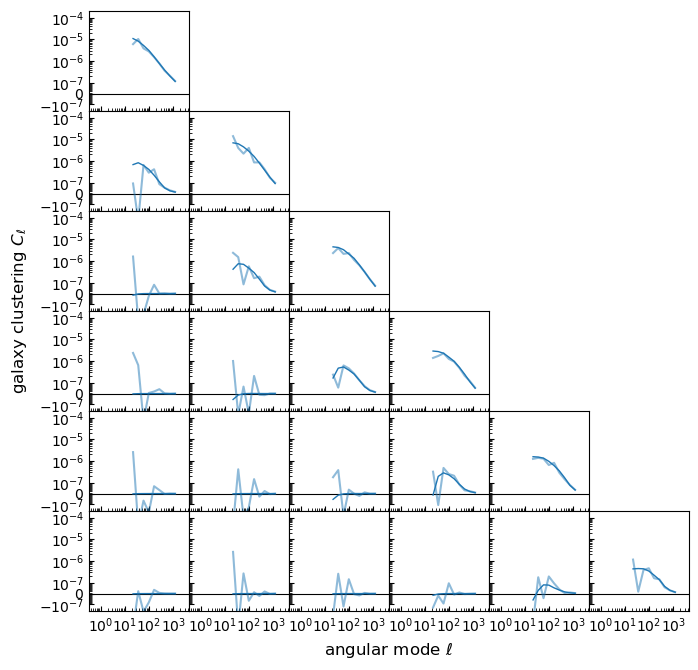

In [15]:
plot_clustering(um_cqs, theory_q);

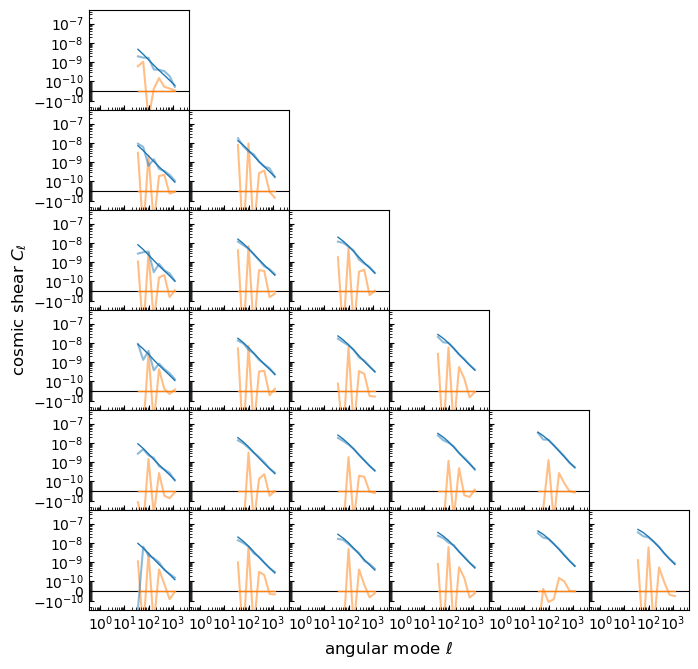

In [16]:
plot_shear(um_cqs, theory_q);

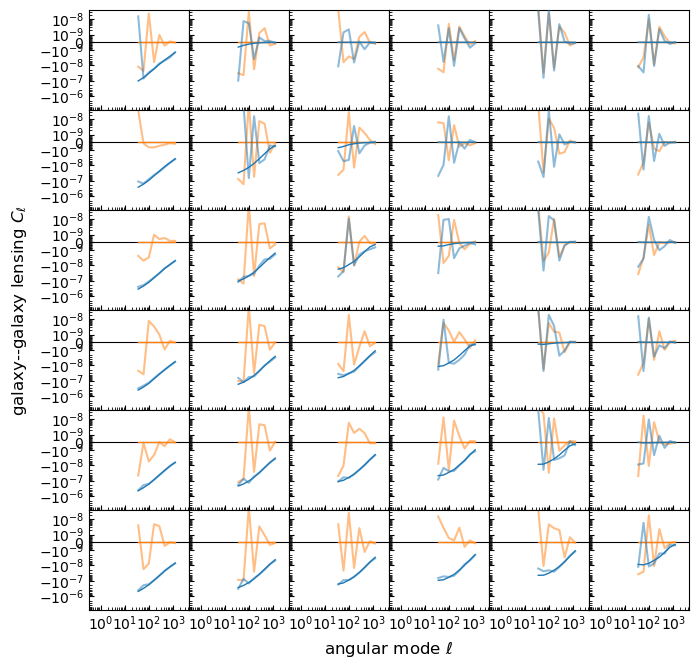

In [17]:
plot_clusteringxshear(um_cqs, theory_q);

## Natural Unmixing

In the nautral unmixing method we account for the effect of the mask in real space. 
Let's start laying down some definitions. Given a complex field:
$$ \gamma(n) = (Q \pm i U)(n) = \sum_{l m} (E_{l m} \mp i B_{l m}) _{\mp 2} Y_{l m}(n)  $$
we can define the correlators:
$$ \xi_{+} = \langle \gamma^* \gamma\rangle  \hspace{6pt}\rm{and}\hspace{6pt} \xi_{-} = \langle \gamma \gamma \rangle $$
Then the associated parital sky correlatiors are given by:
$$ \xi_{\pm}(\theta) = \frac{\tilde{\xi}_{\pm}(\theta)}{\xi^{ww'}(\theta)} $$
which we can also express in terms of linear combinations of the measured $E$ and $B$ angular power spectra:
$$  \tilde{\xi}_{\pm}(\theta) = \sum_l \frac{2l+1}{4\pi}(\tilde{C}^{EE}_l \pm  \tilde{C}^{BB}_l) d^l_{2 \pm 2}(\theta) $$

The natural unmixing method undoes the $E-B$ coupling by exploiting the simple relationship between the full- and partial sky correlation functions:
$$
\xi_{\pm}(\theta) = \frac{\tilde{\xi}_{\pm}(\theta)}{\xi^{ww'}(\theta)} = \nonumber \\ 
= \frac{1}{\xi^{ww'}(\theta)} \sum_l \frac{2l+1}{4\pi}(\tilde{C}^{EE}_l \pm  \tilde{C}^{BB}_l) d^l_{2 \pm 2}(\theta)
$$

Then one can construct a estimator for the full sky angular power spectra by inverting the SWSH transform:
$$
C^{EE}_l = 2\pi \int \frac{1}{2}[\xi_{+}(\theta) + \xi_{-}(\theta)] d^{l}_{22}(\theta) {\rm d}\!\cos{\theta} $$
$$
C^{BB}_l = 2\pi \int \frac{1}{2}[\xi_{+}(\theta) - \xi_{-}(\theta)] d^{l}_{2-2}(\theta) {\rm d}\!\cos{\theta} $$

In [18]:
from heracles.fields import Positions, Shears, Visibility, Weights

mapper = heracles.healpy.HealpixMapper(nside, lmax)
fields = {
    "POS": Positions(mapper, mask="VIS"),
    "SHE": Shears(mapper, mask="WHT"),
    "VIS": Visibility(mapper),
    "WHT": Weights(mapper),
}

In [19]:
nu_d = heracles.natural_unmixing(cls, mask_cls, fields, patch_hole=True)
nu_dq = heracles.binned(nu_d, ledges)

IndexError: boolean index did not match indexed array along axis 0; size of axis is 3001 but size of corresponding boolean axis is 1501

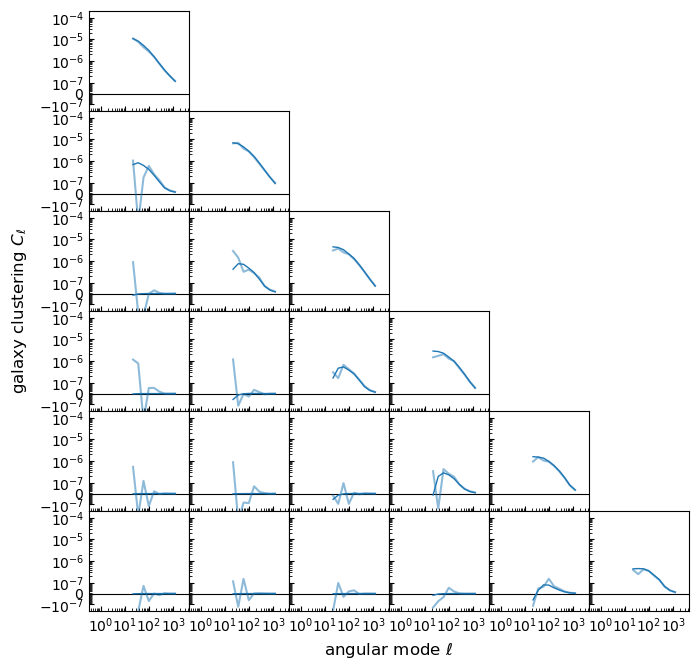

In [ ]:
plot_clustering(nu_dq, theory_q);

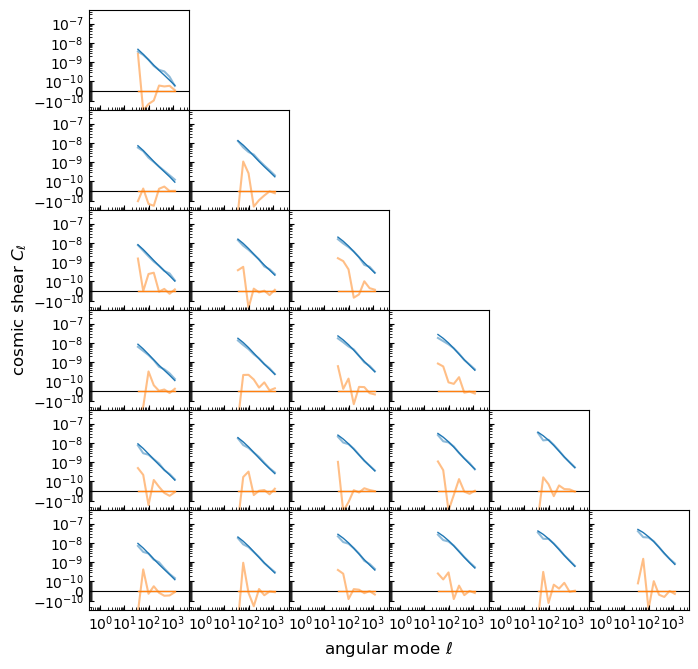

In [ ]:
plot_shear(nu_dq, theory_q);

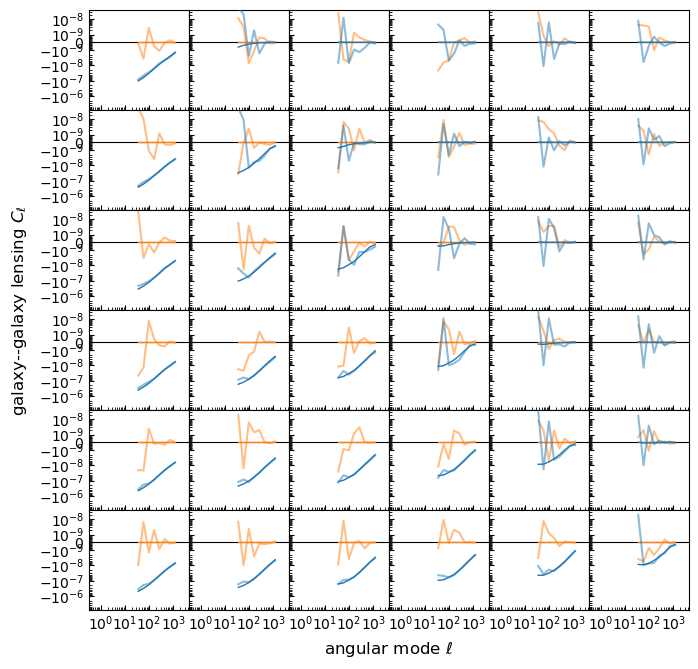

In [ ]:
plot_clusteringxshear(nu_dq, theory_q);